## Collaborative Filtering

In [1]:
# import pandas
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

We will create an recommender engine based on Item Based Collaborative Filtering (IBCF) which searches for the most similar books based on the user ratings. We can download the data from [here](https://drive.google.com/file/d/1WvTmAfO09TCX7xp7uu06__ziic7JnrL5/view?usp=sharing).

In [2]:
book_ratings = pd.read_csv('BX-CSV-Dump/BX-Book-Ratings.csv',sep=";", encoding="latin")
books = pd.read_csv('BX-CSV-Dump/BX-Books.csv',sep=";", encoding="latin", error_bad_lines=False)

/Users/elslb/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 2

* Explore both datasets

In [3]:
book_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


<AxesSubplot:>

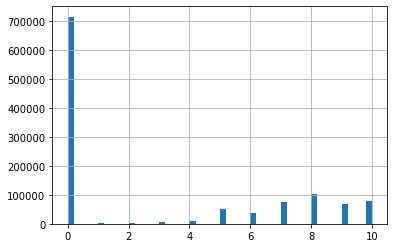

In [4]:
plt.figure(figsize=(6,4))
book_ratings['Book-Rating'].hist(bins=50)
# we can see that most books have a rating of 0
# lets plot a count of the ratings for each book

In [5]:
book_ratings.groupby('ISBN')['Book-Rating'].count()

ISBN
 0330299891    2
 0375404120    2
 0586045007    1
 9022906116    2
 9032803328    1
              ..
cn113107       1
ooo7156103     1
§423350229     1
´3499128624    1
Ô½crosoft      1
Name: Book-Rating, Length: 340556, dtype: int64

In [6]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


* create dataframe with name 'df_book_features' from book_ratings that have `ISBN` as index, `User-ID` as columns and values are `Book-Rating`.
    - The data are quite big so it's OK to use a sample only in case your PC has limited RAM.


In [7]:
merged_df = pd.merge(books, book_ratings, on='ISBN')

In [8]:
df_book_features = pd.DataFrame(data=merged_df, columns=['ISBN', 'User-ID', 'Book-Rating', 'Book-Title'])
df_book_features = df_book_features.set_index('ISBN')
df_book_features.head()

,User-ID,Book-Rating,Book-Title
ISBN,,,
0195153448,2,0,Classical Mythology
0002005018,8,5,Clara Callan
0002005018,11400,0,Clara Callan
0002005018,11676,8,Clara Callan
0002005018,41385,0,Clara Callan


In [9]:
# looks like we have quite a few NaN values here
df_book_features = df_book_features.dropna(axis=0, subset=['Book-Title'])

In [10]:
len(df_book_features.index)

1031136

In [11]:
len(df_book_features.index.unique())

270151

In [12]:
# lets look at the rating count for each book since we know there are many with few ratings
df_book_features['rating_count'] = df_book_features.groupby('ISBN')['Book-Rating'].count()

In [13]:
df_book_features.head(2)

,User-ID,Book-Rating,Book-Title,rating_count
ISBN,,,,
0195153448,2,0,Classical Mythology,1
0002005018,8,5,Clara Callan,14


In [14]:
# awesome, now we want to get the books with multiple ratings and discard the ones with scarce ratings
# lets look at the stats of the rating_count column
pd.set_option('display.float_format', lambda x: '%.3f' %x)
df_book_features['rating_count'].describe()

count   1031136.000
mean         53.795
std         159.507
min           1.000
25%           3.000
50%          10.000
75%          42.000
max        2502.000
Name: rating_count, dtype: float64

In [15]:
# so the 75% percentile of books has 42 ratings
# because we have so many books, I will limit this to the top few percentiles
# lets examine them first
# this will print out all the quantiles starting from 0.9 all the way to 1 in steps of .01
# so we will print out the 90th to 99th percentile
print(df_book_features['rating_count'].quantile(np.arange(0.9, 1, .01)))

0.900   136.000
0.910   150.000
0.920   167.000
0.930   184.000
0.940   209.000
0.950   236.000
0.960   277.000
0.970   350.000
0.980   420.000
0.990   568.000
Name: rating_count, dtype: float64


In [16]:
# the top 5% of books have 236 ratings, so i'll stick with that
threshold = 236
df_book_features = df_book_features[df_book_features['rating_count'] > threshold]

* create the instance of the NearestNeighbors class

In [17]:
nn = NearestNeighbors(n_neighbors=5, metric='cosine', algorithm='brute')

In [25]:
# creating the matrix to compare similarities
# it will be sparse as not all books are rated by all users
user_book_rating = df_book_features.pivot_table(index='Book-Title', columns='User-ID', values='Book-Rating')
user_book_rating.head(3)

User-ID,9,14,16,26,51,67,91,95,99,114,...,278692,278698,278723,278755,278769,278773,278798,278813,278843,278844
Book-Title,,,,,,,,,,,,,,,,,,,,,
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bend in the Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"A Child Called \It\"": One Child's Courage to Survive""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* fit the NearestNeighbors using'df_book_features'

In [26]:
# we need to fill NaN values as 0's before using KNN since it measures distances between the rating vectors
user_book_rating = user_book_rating.fillna(0)

In [27]:
model = nn.fit(user_book_rating)

In [28]:
user_book_rating.head(2)

User-ID,9,14,16,26,51,67,91,95,99,114,...,278692,278698,278723,278755,278769,278773,278798,278813,278843,278844
Book-Title,,,,,,,,,,,,,,,,,,,,,
1st to Die: A Novel,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A Bend in the Road,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [29]:
# testing the model with some recommendations
query_idx = np.random.choice(user_book_rating.shape[0])
distances, idx = nn.kneighbors(np.asarray(user_book_rating.iloc[query_idx, :]).reshape(1, -1), n_neighbors=5)
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(user_book_rating.index[query_idx]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, user_book_rating.index[idx.flatten()[i]], distances.flatten()[i]))

Recommendations for I Know This Much Is True:

1: Icy Sparks, with distance of 0.887260146835728:
2: A Map of the World, with distance of 0.9110561188970664:
3: The Bonesetter's Daughter, with distance of 0.91278595882573:
4: Bridget Jones's Diary, with distance of 0.9132303273743552:


* create function that returns top 5 most similar movies (according to KNN model) for selected ISBN
    * the input will be Book-Title from the DataFrame books 
    * the output will be the Book-Titles of the top 5 most similar books.
    * for every book in the top 5 most similar books, print also the distance from the selected book (ISBN we chose as input to the function)

* create function that returns top 5 most similar movies (according to KNN model) for selected ISBN
    * the input will be Book-Title from the DataFrame books 
    * the output will be the Book-Titles of the top 5 most similar books.
    * for every book in the top 5 most similar books, print also the distance from the selected book (ISBN we chose as input to the function)

In [ ]:
def top_5_similar(book, model=model):
    

* Apply the function to book of your choice